<h1>Import Libraries<h1/>

In [1]:
import os
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets,layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout
from tensorflow.keras import Model


<h1>Features for dataset<h1/>

In [2]:
# Class Names and Class labels for the 2 classification
class_names = ['normal','covid']
# 0 = normal, 1 = Covid 
class_labels = [0,1]

<h1>Data Exploration<h1/>

In [3]:
# Initialize Count 
normalCount=0
covidCount=0
imageCount=0

# Image size: 299 x 299 Pixels grayscale
image_size = (299, 299)

# Read image files - PNG
for class_name in class_names:
    for item in os.listdir(os.getcwd()+f'/dataset_6/{class_name}/'):
        if item.endswith(".png"):
            
            # Check image size 299 x 299
            image_path = os.path.join(os.getcwd(), 'dataset_6', class_name, item)
            # Raise Error if not correct size
            if Image.open(image_path).size != image_size:
                raise ValueError(f"The image size is not {image_size[0]} by {image_size[1]} pixels: {image_path}")
            
            # Increment Counter for images
            imageCount+=1
            if(class_name=='normal'):
                normalCount+=1
            else:
                covidCount+=1
                
print(f"Normal Count: {normalCount}\nCovid Count: {covidCount}\nTotal Count: {imageCount}\n")

Normal Count: 250
Covid Count: 180
Total Count: 430



<h1>Create Dataset for training Model<h1/>

In [4]:
# np array for images. 430 images, 299 pixel, 299 pixels
images = np.empty((imageCount,image_size[0],image_size[1]))
# np arraay for image labels, 430 labels
labels = np.empty((imageCount,1))

# Index for assigning image to np array loction
index=0

# Loop Through normal/covid img folders
for label,class_name in enumerate(class_names):
    # Iterate through items in folder
    for item in os.listdir(os.getcwd()+f'/dataset_6/{class_name}/'):
        # if item is png image
        if item.endswith(".png"):
            image_path = os.getcwd()+f'/dataset_6/{class_name}/{item}'
            # Read item into np array
            image = np.array(Image.open(image_path))
            # Normalize image from 0-255, to 0 to 1
            image = image/255 #???? Normalize?
            # Add image to np array
            images[index]=image
            # Add label to np array
            labels[index]=label
            index+=1
# Convert labels to INT
labels=np.array(labels,dtype=np.int32)

<h1>Visualize images from normal and covid folder<h1/>

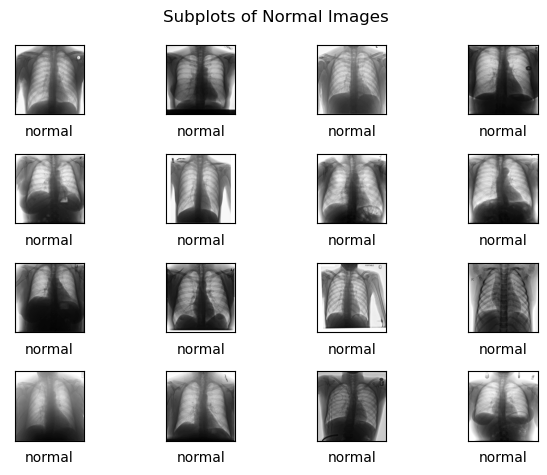

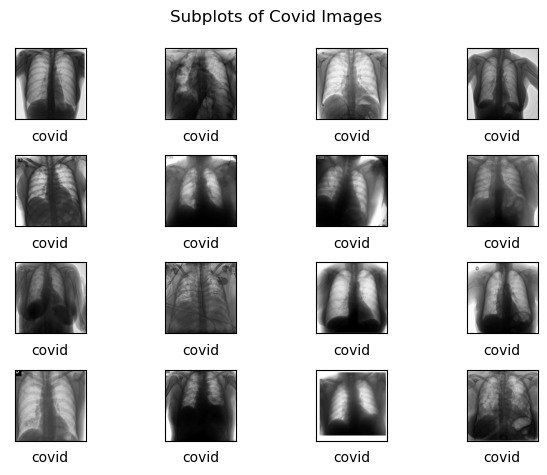

In [5]:
#Visualization for both normal and Covid
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[labels[i][0]])
plt.subplots_adjust(top=0.9) 
plt.suptitle("Subplots of Normal Images")  
plt.tight_layout()
plt.show()


for i in range(normalCount,normalCount+16):
    plt.subplot(4,4,i-normalCount+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(labels[i][0])])
plt.tight_layout()
plt.subplots_adjust(top=0.9) 
plt.suptitle("Subplots of Covid Images")  
plt.show()

<h1>Splt dataset into training and testing dataset <h1/>

In [6]:
#Fixed seed
seed = 88
# Train Test Split for training machine learning and Deep Learning
# Split percentage 80% for train, 20% for test. 
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=seed
)

<h1>Visualize Training Dataset<h1/>

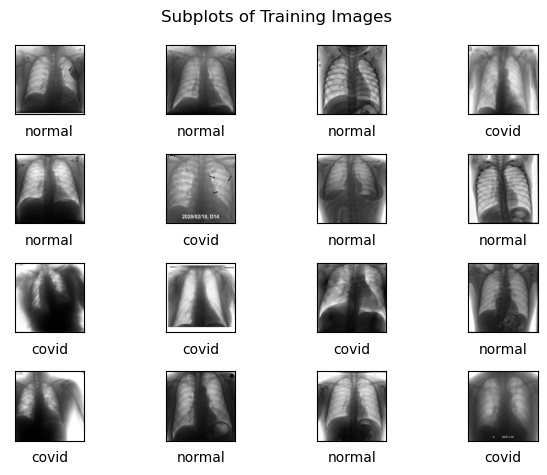

In [7]:
#Visualize new dataset of both covid and normal lungs
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.subplots_adjust(top=0.9) 
plt.suptitle("Subplots of Training Images")  
plt.tight_layout()
plt.show()

<h1>Auto-Encoder<h1/>

In [12]:
# Compare Images function
def show_imgs(original_imgs, reconstructed_imgs, n=10):
    plt.figure(figsize=(40, 10))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_imgs[i])
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_imgs[i])
        plt.title("Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
# Auto Encoder Function
class Autoencoder(Model):
    def __init__(self, dim):
        super(Autoencoder, self).__init__()
        self.dim = dim
        self.encoder = Sequential([
            Flatten(input_shape=(299, 299)),
            Dense(250, activation='relu'),  # Increase complexity with more neurons
            Dense(200, activation='relu'),  
            Dense(150, activation='relu'),  
            #Dense(128, activation='relu'),
#             Dense(32, activation='relu')
        ])
        self.decoder = Sequential([
            Dense(200, activation='relu', input_shape=(150,)),
            #Dense(128, activation='relu'),
            Dense(250, activation='relu'),
#             Dropout(0.2),  # Add dropout for regularization
            Dense(299 * 299, activation='sigmoid'),
            Reshape((299, 299))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Compile the model with adam optimizer, mse as loss function, and use accuracy as metric
autoencoder = Autoencoder(dim=299)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the model usng 200 Epochs
autoencoder.fit(train_images, train_images, epochs=100, validation_data=(test_images, test_images))

# Encode test images
encoded_test_images = autoencoder.encoder.predict(test_images)
# Decode Test Images
decoded_test_images = autoencoder.decoder(encoded_test_images)



Epoch 1/100
11/11 [==============================] - 1s 54ms/step - loss: 0.0486 - accuracy: 0.0091 - val_loss: 0.0394 - val_accuracy: 0.0125
Epoch 2/100
11/11 [==============================] - 1s 48ms/step - loss: 0.0378 - accuracy: 0.0134 - val_loss: 0.0369 - val_accuracy: 0.0155
Epoch 3/100
11/11 [==============================] - 1s 49ms/step - loss: 0.0355 - accuracy: 0.0142 - val_loss: 0.0328 - val_accuracy: 0.0146
Epoch 4/100
11/11 [==============================] - 1s 48ms/step - loss: 0.0302 - accuracy: 0.0140 - val_loss: 0.0310 - val_accuracy: 0.0135
Epoch 5/100
11/11 [==============================] - 1s 48ms/step - loss: 0.0277 - accuracy: 0.0142 - val_loss: 0.0278 - val_accuracy: 0.0153
Epoch 6/100
11/11 [==============================] - 1s 48ms/step - loss: 0.0266 - accuracy: 0.0143 - val_loss: 0.0273 - val_accuracy: 0.0137
Epoch 7/100
11/11 [==============================] - 1s 48ms/step - loss: 0.0254 - accuracy: 0.0144 - val_loss: 0.0265 - val_accuracy: 0.0149
Epoch 

11/11 [==============================] - 1s 47ms/step - loss: 0.0053 - accuracy: 0.0905 - val_loss: 0.0198 - val_accuracy: 0.0345
Epoch 59/100
11/11 [==============================] - 1s 51ms/step - loss: 0.0051 - accuracy: 0.0910 - val_loss: 0.0193 - val_accuracy: 0.0358
Epoch 60/100
11/11 [==============================] - 1s 51ms/step - loss: 0.0049 - accuracy: 0.0918 - val_loss: 0.0196 - val_accuracy: 0.0375
Epoch 61/100
11/11 [==============================] - 1s 47ms/step - loss: 0.0048 - accuracy: 0.0928 - val_loss: 0.0200 - val_accuracy: 0.0339
Epoch 62/100
11/11 [==============================] - 1s 46ms/step - loss: 0.0046 - accuracy: 0.0987 - val_loss: 0.0198 - val_accuracy: 0.0333
Epoch 63/100
11/11 [==============================] - 1s 47ms/step - loss: 0.0045 - accuracy: 0.0979 - val_loss: 0.0201 - val_accuracy: 0.0388
Epoch 64/100
11/11 [==============================] - 1s 47ms/step - loss: 0.0045 - accuracy: 0.1002 - val_loss: 0.0197 - val_accuracy: 0.0377
Epoch 65/100

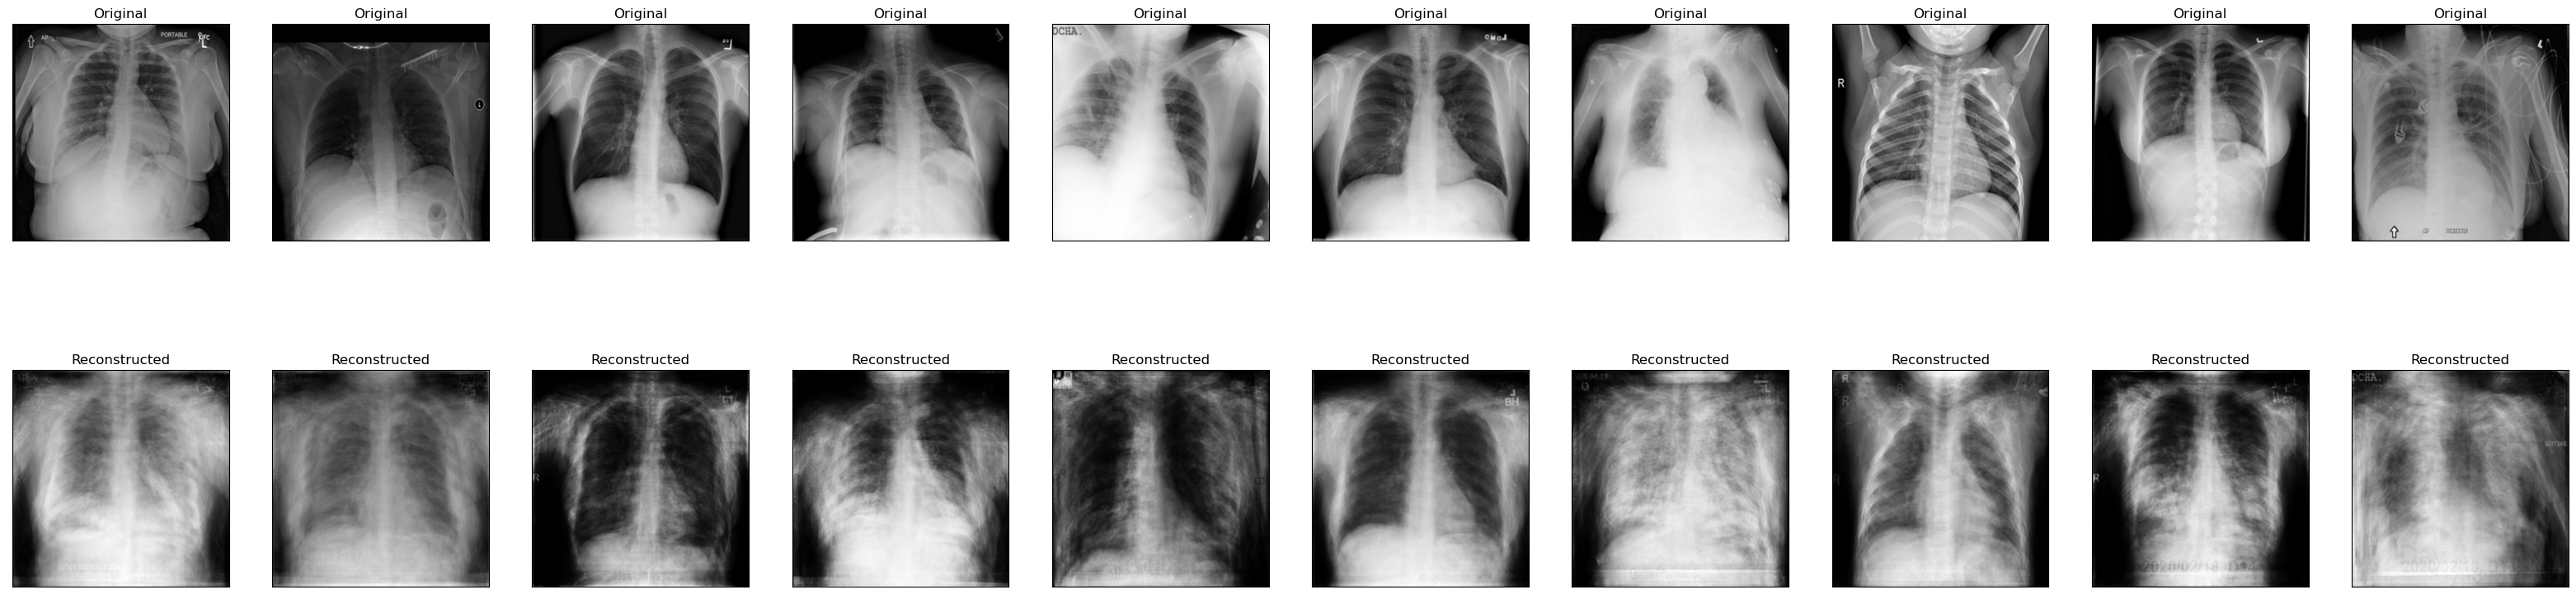

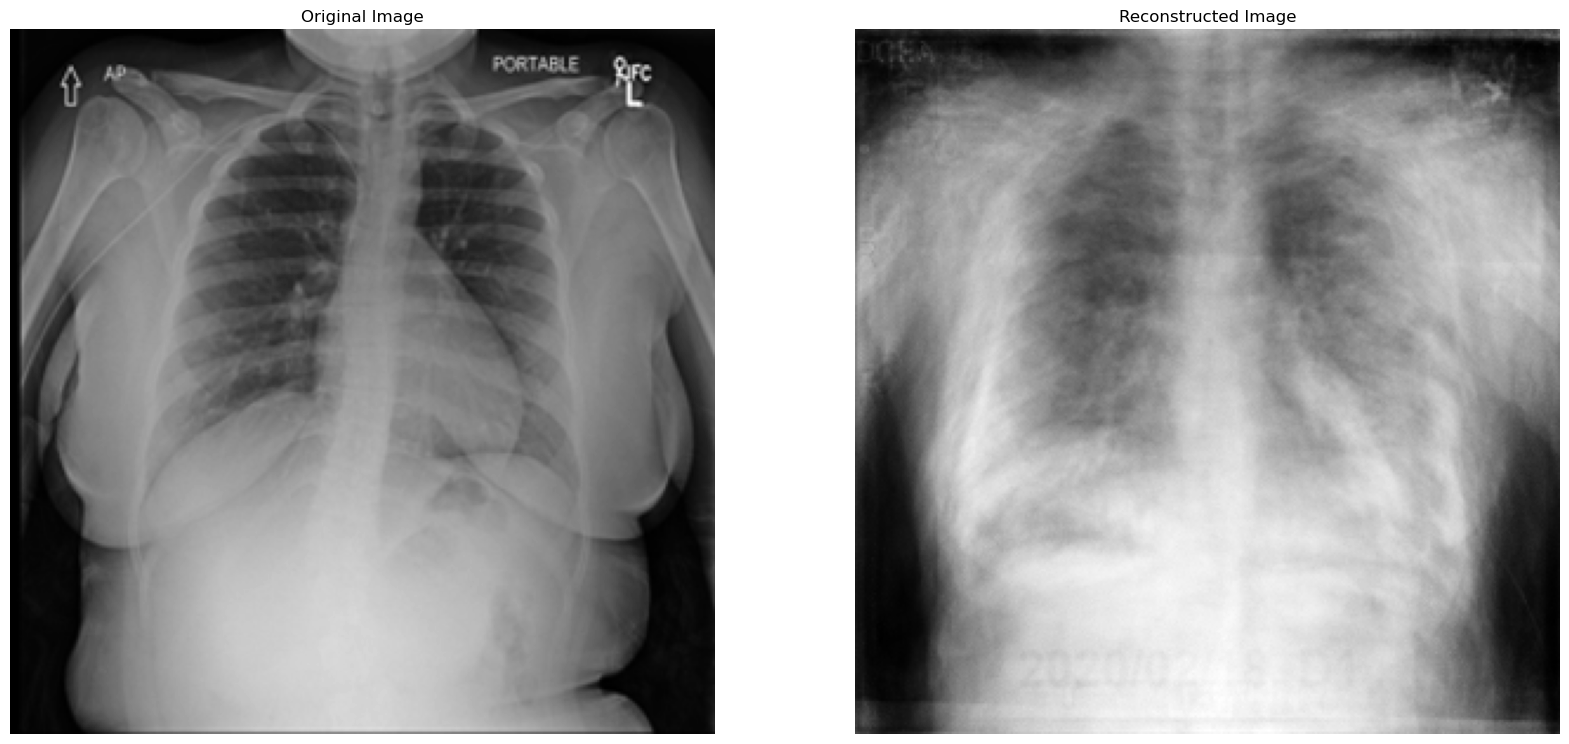

In [13]:
#Visualize Decoded images with original 
show_imgs(test_images, decoded_test_images)

#Visualize Decoded images with original (Enlarged)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_images[0], cmap=plt.cm.binary)
plt.title("Original Image")
plt.gray()
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(decoded_test_images[0], cmap=plt.cm.binary)
plt.title("Reconstructed Image")
plt.gray()
plt.axis('off')

plt.show()